In [7]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons
from copy import deepcopy

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot
from collections import defaultdict
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping
from poliastro.extra_util import get_galilean_orbs, ecliptic_slingshot, get_galilean_ephemerides
#from poliastro.extra_util import get_single_burn_elliptical_hohmann
solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [8]:
start_date= time.Time("2037-06-11 00:01", scale="utc").tdb
end_date= time.Time("2037-09-21 00:01", scale="utc").tdb
epochs=time_range(start=start_date,end=end_date,periods=50)


r_perijove = Jupiter.R+200000 * u.km
r_apijove = Jupiter.R+5e6*u.km
a_start = (r_perijove+r_apijove)/2
ecc_start = (r_perijove-r_apijove)/(r_perijove+r_apijove)

starship_orb=Orbit.from_classical(
Jupiter, a_start, ecc_start, callisto_orb.inc, 
callisto_orb.raan, 0*u.deg, -180*u.deg,
start_date,plane=Planes.EARTH_ECLIPTIC)


print(starship_orb.period.to(u.day))


28.208939748341336 d


In [9]:
ephemerides = get_galilean_ephemerides(start_date, end_date)

# # Access like this:
europa_ephem = ephemerides[Europa]
io_ephem = ephemerides[Io]
ganymede_ephem = ephemerides[Ganymede]
callisto_ephem = ephemerides[Callisto]
galilean_orbs = get_galilean_orbs(start_date,start_date+10*u.day)

# Access like this:
europa_orb = galilean_orbs[Europa]
print(europa_orb)
europa_orb= Orbit.from_ephem(attractor=Jupiter,ephem=europa_ephem,epoch=start_date)
ganymede_orb= Orbit.from_ephem(attractor=Jupiter,ephem=ganymede_ephem,epoch=start_date)
io_orb= Orbit.from_ephem(attractor=Jupiter,ephem=io_ephem,epoch=start_date) 
callisto_orb= Orbit.from_ephem(attractor=Jupiter,ephem=callisto_ephem,epoch=start_date)

665064 x 676992 km x 2.0 deg orbit around Jupiter (♃) at epoch 2037-06-11 00:02:09.185 (TDB)


In [12]:
tof=20*u.day
body_orb=callisto_orb.propagate(start_date+tof)

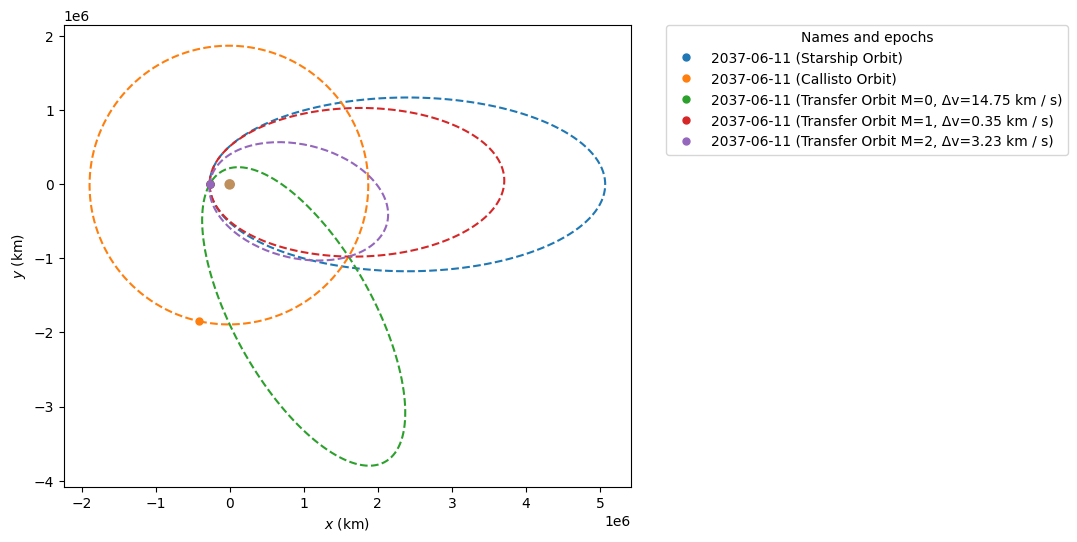

In [16]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(starship_orb, label="Starship Orbit")
plotter.plot(callisto_orb, label="Callisto Orbit")
for j in range(3):
    lambert=Maneuver.lambert(starship_orb,body_orb,M=j)
    burn=lambert[0]
    dv=np.linalg.norm(burn[1])
    final_orb,dummy=starship_orb.apply_maneuver(lambert,intermediate=True)
    plotter.plot(final_orb, label=f"Transfer Orbit M={j}, Δv={dv.to(u.km/u.s):.2f}")